In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import library that needed for colab
from google.colab import drive # colab only
from google.colab import files # colab only

# To remove all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile
import pandas as pd
import requests
import random
import calendar
import time

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow import lite, cast, float32
from tensorflow import saved_model

from imblearn.over_sampling import RandomOverSampler 

In [3]:
import tensorflow
import PIL
print(tensorflow.__version__)
print(np.__version__)
print(PIL.__version__)

2.12.0
1.22.4
8.4.0


In [3]:
# To mounting Google Drive

def google_drive_mount(mounting=True):
  if mounting:
    drive.mount('/content/drive')

In [4]:
# Download the file

def download_file(urls, unzip=True, remove_after_unzip=False, google_drive=False, filename='tmp', ext='zip'):

  url = urls
  CHUNK_SIZE = 32768
  file_tmp = f'{filename}.{ext}'

  # If Downloading from Google Drive
  if google_drive:

    # Get the token
    def get_confirm_token(response):
      
      for key, value in response.cookies.items():
        if key.startswith('download_warning'):
          return value
      return None
    
    url_raw = 'https://docs.google.com/uc?export=download'
    file_id = url.split('/')[-2] # Split the file id
    session = requests.Session() # Get session
    response = session.get(url_raw, params={'id': file_id}, stream=True) # Get the response
    token = get_confirm_token(response) # Get the token

    # If there is token
    if token:
      response = session.get(url_raw, params={'id': file_id, 'confirm': token}, stream=True) # Get the response
    
    # Save the response as zip file
    with open(file_tmp, 'wb') as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk:
          f.write(chunk)
  
  # If not from Google Drive
  else:
    filedata = get_file(origin=url, fname=os.path.join(os.getcwd(), file_tmp)) # Get the response from URL

  # Extract the zip files
  if unzip:
    local_zip = file_tmp
    zip_ref = zipfile.ZipFile(local_zip, 'r') # Extract 
    zip_ref.extractall(f'{os.getcwd()}/') # Extract
    zip_ref.close()
    # Remove the zip file after unzip
    if remove_after_unzip:
      os.remove(file_tmp)  
  
  # If not a zip file
  else:
    return file_tmp

In [5]:
# Load the saved models/checkpoints models from Google Drive

def load_models(url, summary=False, filenames='tmp'):
  model_download = download_file(url, unzip=False, remove_after_unzip=True, google_drive=True, ext="h5", filename=filenames)  
  model = load_model(model_download)
  if summary:
    model.summary()
  return model
     

In [6]:
class_names = ['AKIEC','BCC','BKL','DF','NV','MEL','VASC']

class_names_long = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesion']

In [7]:
# Load the TF-Serving
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  13316      0 --:--:-- --:--:-- --:--:-- 13316
OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:1

In [8]:
os.getcwd()

'/content'

In [9]:
cd /content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/skin-cancer-mnist-ham10000

/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/skin-cancer-mnist-ham10000


In [10]:
os.getcwd()

'/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/skin-cancer-mnist-ham10000'

In [11]:
for files in os.listdir(f'{os.getcwd()}/HAM10000'):
  os.remove(f'{os.getcwd()}/HAM10000/{files}')
os.removedirs(f'{os.getcwd()}/HAM10000')

In [12]:
# Resizing and moving function
def resize_img(SOURCE, DEST, SIZE=299):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  print(len(files))
  for filename in files:
    if '.jpg' in filename:
      img = cv2.imread(f"{SOURCE}{filename}")
      resize_img = cv2.resize(img, (SIZE,SIZE))
      cv2.imwrite(f"{DEST}/{filename}", resize_img)
      # move(f"{SOURCE}/{filename}",f"{DEST}/{filename}")

os.mkdir(f'{os.getcwd()}/HAM10000') # Because file in zip is separate by 2 parts, 
                                    # so we create new directory to save all parts
                                    # in one folder to make resizing more easy

# Resizing the image
# resize_img(f'{os.getcwd()}/HAM10000_images_part_1/',f'{os.getcwd()}/HAM10000/')
# resize_img(f'{os.getcwd()}/HAM10000_images_part_2/',f'{os.getcwd()}/HAM10000/')
folder_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
for folder_name in folder_list:
  resize_img(f'{os.getcwd()}/skin/{folder_name}/',f'{os.getcwd()}/HAM10000/')
# resize_img(f'{os.getcwd()}/ham10000_images_part_2/',f'{os.getcwd()}/HAM10000/')

# Remove some dir, to make directory more clean
# os.rmdir(f'{os.getcwd()}/HAM10000_images_part_1')
# os.rmdir(f'{os.getcwd()}/HAM10000_images_part_2')
# os.rmdir(f'{os.getcwd()}/ham10000_images_part_1')
# os.rmdir(f'{os.getcwd()}/ham10000_images_part_2')

# Checking how much file in HAM10000 to make sure there is no file lost
print(len(os.listdir(f'{os.getcwd()}/HAM10000'))) # 10015

327
514
1099
115
1113
6705
142
10015


In [13]:
print(len(os.listdir(f'{os.getcwd()}/HAM10000'))) # 10015

10015


In [14]:
for files in os.listdir(f'{os.getcwd()}/data'):
  os.remove(f'{os.getcwd()}/data/{files}')
os.removedirs(f'{os.getcwd()}/data')

In [15]:
# Converting lesion type to more readable format
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Reading the csv file
df = pd.read_csv(f'{os.getcwd()}/HAM10000_metadata.csv')

# Adding more columns in csv
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

# Because too many Melanocytic Nevi pictures, so we pick randomly only 1205 samples
df_random = df[df['cell_type'] == 'Melanocytic nevi'].sample(n=1205, random_state=1)
df = df.drop(df[df['cell_type']== 'Melanocytic nevi'].index)
df = df.append(df_random)

# Writing new metadata.csv
df.to_csv(f'{os.getcwd()}/metadata.csv')

# Then delete unnecessary files on HAM10000 then moved to HAM10000-fix
df_read = pd.read_csv(f'{os.getcwd()}/metadata.csv')
os.mkdir(f'{os.getcwd()}/data')
for i in range(len(df_read)):
  move(f"{os.getcwd()}/HAM10000/{df_read['image_id'].values[i]}.jpg", f"{os.getcwd()}/data/{df_read['image_id'].values[i]}.jpg")

# Then delete unnecessary files
# rmtree(f'{os.getcwd()}/HAM10000/')
# os.remove(f'{os.getcwd()}/hmnist_28_28_L.csv')
# os.remove(f'{os.getcwd()}/hmnist_28_28_RGB.csv')
# os.remove(f'{os.getcwd()}/hmnist_8_8_L.csv')
# os.remove(f'{os.getcwd()}/hmnist_8_8_RGB.csv')

In [16]:
# After adjusting
df = pd.read_csv(f'{os.getcwd()}/metadata.csv')
df['cell_type'].value_counts()

Melanocytic nevi                 1205
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64

In [17]:
def define_dataset(csv, unique=False):

  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['cell_type_idx'].values # Define the Labels

  if unique: # Counting unique values
      df['cell_type'].value_counts() # Returning amout of unique value
  
  return img, target

In [18]:
# Defining dataset into labels and features
img, target = define_dataset(f'{os.getcwd()}/metadata.csv')

In [19]:
def split_data(x, y, test_size=0.2, validation_size=0.05, balancing=False):
  
  # Balancing the datasets, if the datasets not balanced so this function will balanced them
  def balancing_dataset(x_train, x_val, y_train, y_val):
    
    # Balancing with OverSampler method from Imbalanced Learn
    # Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    oversample = RandomOverSampler()
    x_train, y_train  = oversample.fit_resample(x_train.values.reshape(-1,1),y_train)
    x_val, y_val  = oversample.fit_resample(x_val.values.reshape(-1,1),y_val)
    
    return x_train, x_val, y_train, y_val
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_size)

  # If balancing is True, so the datasets will be balancing
  if balancing:
    x_train, x_val, y_train, y_val = balancing_dataset(x_train, x_val, y_train, y_val)
  
  # Print the results of splitting
  print("Train: ", x_train.shape[0]), print("Val: ", x_val.shape[0]), print("Test: ", x_test.shape[0]), 
  
  return x_train, x_val, x_test, y_train, y_val, y_test

In [20]:
# Splitting into train, valid and test with balancing all of the data
x_train_list, x_val_list, x_test_list, y_train, y_val, y_test = split_data(img, target, balancing=True, test_size=0.2, validation_size=0.05)

Train:  8064
Val:  434
Test:  903


In [21]:
f"{os.getcwd()}/data/{x_train_list[0][0]}.jpg"

'/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/skin-cancer-mnist-ham10000/data/ISIC_0025576.jpg'

In [22]:
def to_tensor(image_paths, oversample=True, size=64):
 
  imgs = []
  cwd = os.getcwd()
  for i in tqdm(image_paths):
    if oversample: # If datasets is balanced
      img = load_img(f"{cwd}/data/{i[0]}.jpg", target_size=(size, size)) # Load the Image then resized them
    else:
      img = load_img(f"{cwd}/data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs

In [23]:
# We only balanced the Train and Validation data
# So, if we set oversample to True for x_test
# There will be errors
x_train = to_tensor(x_train_list, size=150)
x_val = to_tensor(x_val_list, size=150)
# x_test = to_tensor(x_test)

# Unbalanced datasets
#x_train = to_tensor(x_train, oversample=False)
#x_val = to_tensor(x_val, oversample=False)
x_test = to_tensor(x_test_list, oversample=False, size=150) # Since this is only the test dataset, no need to balanced this

100%|██████████| 903/903 [00:02<00:00, 339.19it/s]


In [24]:
def show_batch(x, y, figsize=12, subfigsize=5, n=25, no_axis=True):

  plt.figure(figsize=(figsize, figsize)) # Defining figure of the datasets
  
  for i in range(n): # Iterating through n datasets randomly
      ax = plt.subplot(subfigsize, subfigsize, i+1) # Defining frontend of figure
      plt.imshow(x[i]) # Showing the picture from datasets
      plt.title(class_names[y[i]]) # Showing class names
      
      # Remove axis from the figure
      if no_axis:
        plt.axis('off')

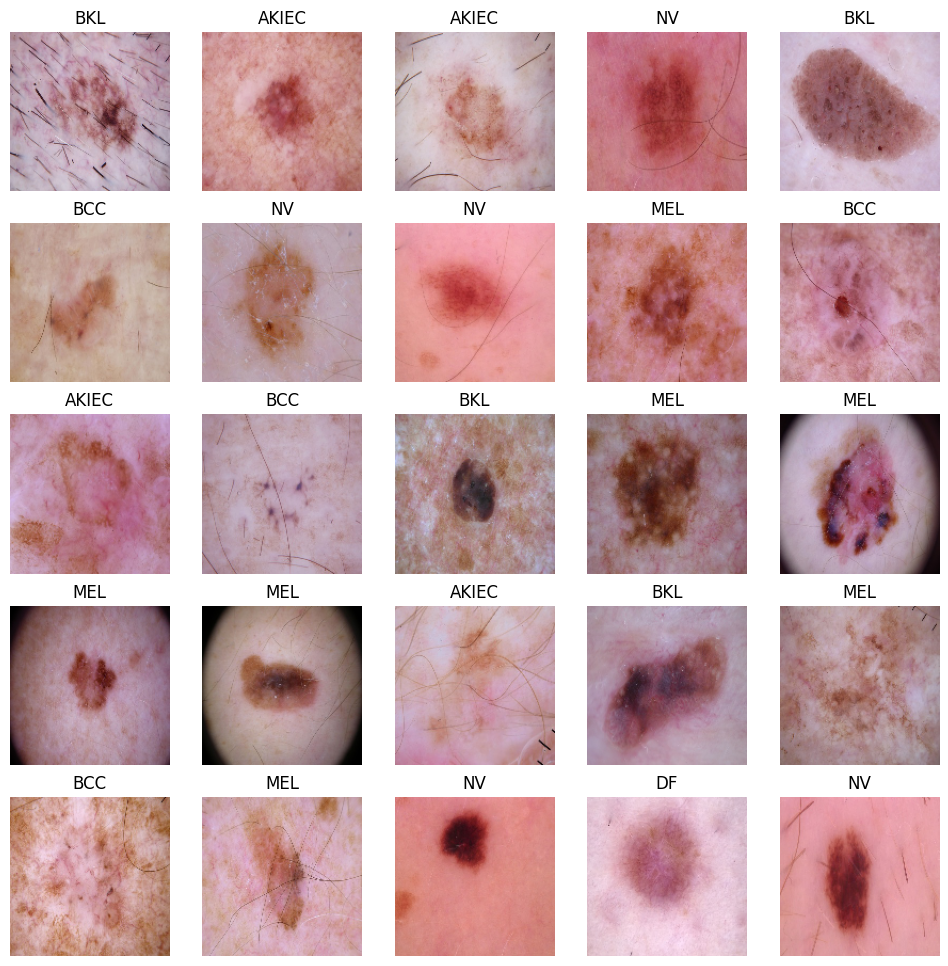

In [25]:
# Showing images from the datasets
show_batch(x_test, y_test)

In [26]:
# Prediction the test datasets portion

def predictions(model, x_test, y_test, accuracy=True, axis=1):
  
  predictions = model.predict(x_test) # Predict the test datasets
  pred = np.argmax(predictions, axis=axis) # Showing the greatest value from predictions (range: 0-1, biggest is 1)
  
  # Printing the accuracy, with comparing predictions with labels of test datasets portion
  if accuracy: 
    print("\nAccuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))
  
  return pred, x_test, y_test

In [7]:
cd /content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/model

/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/model


In [28]:
!git clone https://github.com/google/automl.git

fatal: destination path 'automl' already exists and is not an empty directory.


In [9]:
cp /content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/model/maxvit_tiny_224_imagenet.h5 /usr/local/lib/python3.9/dist-packages/keras/models/maxvit_tiny_224_imagenet.h5

In [10]:
from automl.lion import lion_tf2

In [35]:
import math
from keras.callbacks import Callback
from keras import backend as K

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [44]:
# Defining the models

def trainable_model(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=32, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, callbacks=None, generator=True,
                    checkpoint=None):
  
  dataset = (x_train, y_train, x_val, y_val)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  train_dataset = generators.flow(trainX, trainY, batch_size=BATCH_SIZE)
  valid_dataset = generators.flow(valX, valY, batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                  zoom_range=zoom_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  shear_range=shear_range,
                                  horizontal_flip=horizontal_flip,
                                  fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX, valY, batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model == 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model == 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model == 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model == 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model == 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model == 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model == 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model == 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model == 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
    
  model = Sequential([base_model, 
                      AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                      Flatten(), 
                      Dense(64, activation='relu'),
                      Dropout(dropout), 
                      Dense(16, activation='relu'),
                      Dense(7, activation='softmax', kernel_regularizer=l2(regularizer)),
  ])
  model.compile(#optimizer=lion_tf2.Lion(learning_rate=0.00005),
                optimizer=Adam(lr=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()
  
  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose,
                      callbacks=[callbacks, checkpoint])
  
  _ = predictions(model, x_test, y_test)

  return history, model
     

In [45]:
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
#              CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)]
# callback = keras.callbacks.ModelCheckpoint(filepath=dataset_path+'/CoAt_best_model(6-1_random_label_corrected)_valNorm.h5',
#                                            monitor='val_accuracy', # 'val_f1_m
#                                            mode='max',
#                                            verbose=1,
#                                            save_best_only=True)

checkpoints = ModelCheckpoint('HAM10000_Xception_dropout015_adam.h5', 
                              monitor='val_loss',mode='min',verbose=1, save_best_only=True)

history, model = trainable_model(x_train, y_train, x_val, y_val, x_test, y_test,
                                fine_tuning=True, epochs=50, base_model='Xception', 
                                dropout=0.15, regularizer=0.1, batch_size=32,
                                callbacks=callbacks, summary=True, checkpoint=checkpoints)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 average_pooling2d_6 (Averag  (None, 2, 2, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 64)                524352    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                      

In [52]:
os.getcwd()

'/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/model'

In [46]:
import pickle
dataset_path = '/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/skin-cancer-mnist-ham10000'
# pickle.load(dataset_path+'/EffV2M_trainHistoryDict_valNorm')
with open(dataset_path+'/Xception_trainHistory_adam_87acc', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
with open(dataset_path+'/Xception_trainHistory_lion_96acc', "rb") as file:
    read_variables = pickle.load(file)
history = pd.DataFrame({'history':read_variables})

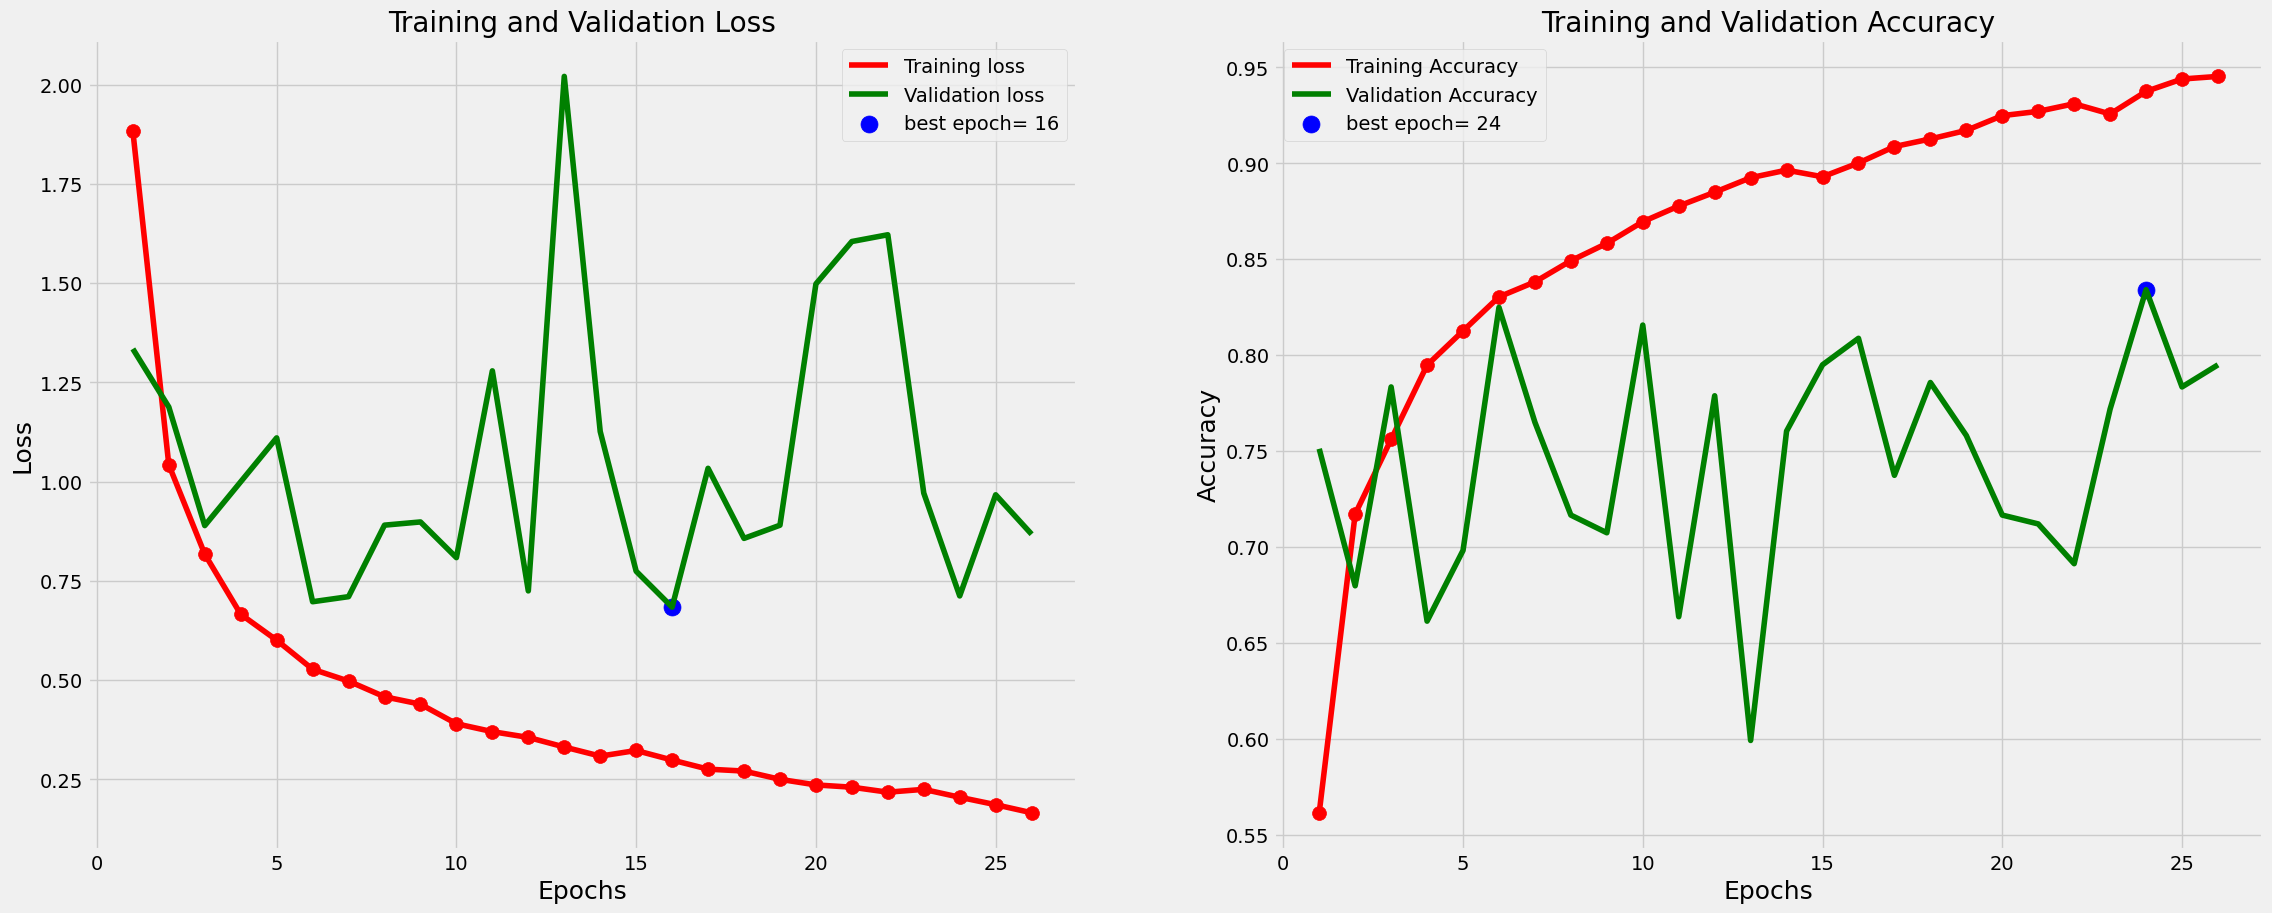

In [47]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    # tf1=tr_data.history['f1_m']
    # vf1=tr_data.history['val_f1_m']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    # indexf1=np.argmax(vf1)
    # vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    # f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    # axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    # axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    # index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    # tf1max=tf1[index_tf1]
    # index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    # vf1max=vf1[index_vf1]
    # axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    # # axes[2].scatter(Epochs, tf1, s=100, c='red')
    # axes[2].set_title('Training and Validation F1 score')
    # axes[2].set_xlabel('Epochs', fontsize=18)
    # # axes[2].set_ylabel('F1  score', fontsize=18)
    # axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

tr_plot(history)

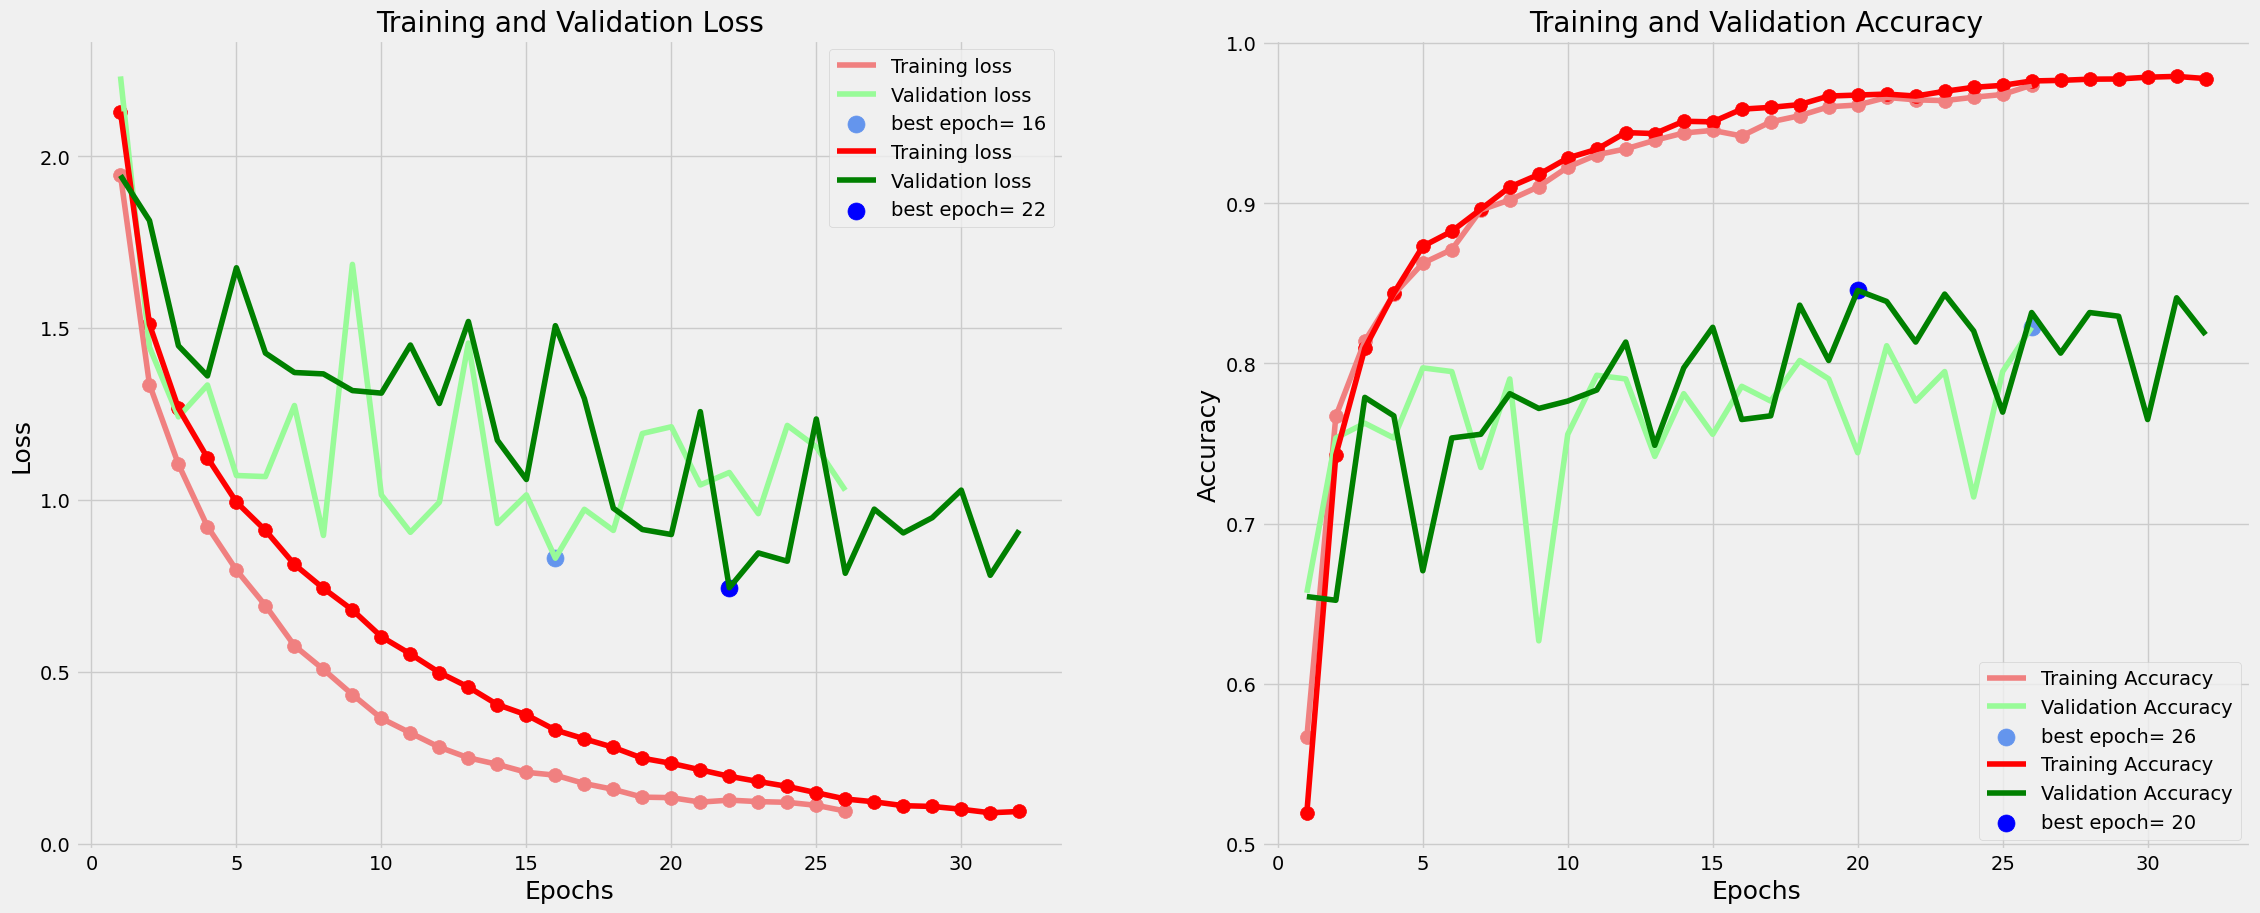

In [51]:
def tr_plot(tr_data1, tr_data2):
    start_epoch=0
    #Plot the training and validation data
    tacc1=tr_data1.history['accuracy']
    tloss1=tr_data1.history['loss']
    vacc1=tr_data1.history['val_accuracy']
    vloss1=tr_data1.history['val_loss']
    tacc2=tr_data2.history['accuracy']
    tloss2=tr_data2.history['loss']
    vacc2=tr_data2.history['val_accuracy']
    vloss2=tr_data2.history['val_loss']
    # tf1=tr_data.history['f1_m']
    # vf1=tr_data.history['val_f1_m']    
    Epoch_count=len(tacc1)
    Epochs1=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs1.append(i+1)
    Epoch_count=len(tacc2)
    Epochs2=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs2.append(i+1) 
    index_loss1=np.argmin(vloss1)#  this is the epoch with the lowest validation loss
    val_lowest1=vloss1[index_loss1]
    index_acc1=np.argmax(vacc1)
    acc_highest1=vacc1[index_acc1]
    index_loss2=np.argmin(vloss2)#  this is the epoch with the lowest validation loss
    val_lowest2=vloss2[index_loss2]
    index_acc2=np.argmax(vacc2)
    acc_highest2=vacc2[index_acc2]
    # indexf1=np.argmax(vf1)
    # vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label1='best epoch= '+ str(index_loss1+1 +start_epoch)
    vc_label1='best epoch= '+ str(index_acc1 + 1+ start_epoch)
    sc_label2='best epoch= '+ str(index_loss2+1 +start_epoch)
    vc_label2='best epoch= '+ str(index_acc2 + 1+ start_epoch)
    # f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs1,tloss1, 'lightcoral', label='Training loss')
    axes[0].plot(Epochs1,vloss1,'palegreen',label='Validation loss' )
    axes[0].scatter(index_loss1+1 +start_epoch,val_lowest1, s=150, c= 'cornflowerblue', label=sc_label1)
    axes[0].scatter(Epochs1, tloss1, s=100, c='lightcoral')
    axes[0].plot(Epochs2,tloss2, 'r', label='Training loss')
    axes[0].plot(Epochs2,vloss2,'g',label='Validation loss' )
    axes[0].scatter(index_loss2+1 +start_epoch,val_lowest2, s=150, c= 'blue', label=sc_label2)
    axes[0].scatter(Epochs2, tloss2, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs1,tacc1,'lightcoral',label= 'Training Accuracy')
    axes[1].scatter(Epochs1, tacc1, s=100, c='lightcoral')
    axes[1].plot (Epochs1,vacc1,'palegreen',label= 'Validation Accuracy')
    axes[1].scatter(index_acc1+1 +start_epoch,acc_highest1, s=150, c= 'cornflowerblue', label=vc_label1)
    axes[1].plot (Epochs2,tacc2,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs2, tacc2, s=100, c='red')
    axes[1].plot (Epochs2,vacc2,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc2+1 +start_epoch,acc_highest2, s=150, c= 'blue', label=vc_label2)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    # axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    # axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    # index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    # tf1max=tf1[index_tf1]
    # index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    # vf1max=vf1[index_vf1]
    # axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    # # axes[2].scatter(Epochs, tf1, s=100, c='red')
    # axes[2].set_title('Training and Validation F1 score')
    # axes[2].set_xlabel('Epochs', fontsize=18)
    # # axes[2].set_ylabel('F1  score', fontsize=18)
    # axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 
with open(dataset_path+'/Xception_trainHistory_lion_82acc', "rb") as file:
    read_variables = pickle.load(file)
history1 = pd.DataFrame({'history':read_variables})
with open(dataset_path+'/Xception_trainHistory_lion_96acc', "rb") as file:
    read_variables = pickle.load(file)
history2 = pd.DataFrame({'history':read_variables})
tr_plot(history1, history2)

In [79]:
history2.history['val_loss'][-1]

0.911441445350647

In [ ]:
from collections import Counter
train_label = Counter(y_train)
print(train_label)

Counter({2: 1149, 1: 1149, 5: 1149, 4: 1149, 0: 1149, 3: 1149, 6: 1149})


Counter({2: 1149, 1: 1149, 5: 1149, 4: 1149, 0: 1149, 3: 1149, 6: 1149})


<BarContainer object of 7 artists>

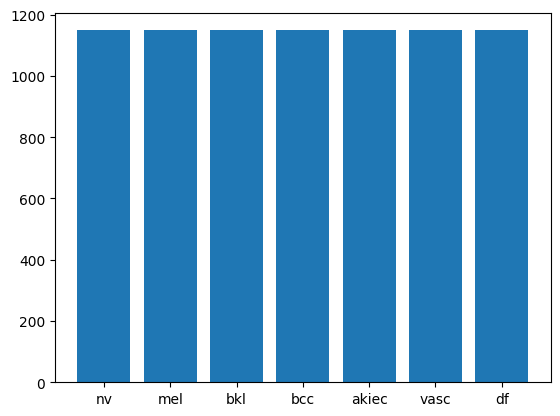

In [ ]:
from collections import Counter
train_label = Counter(y_train)
print(train_label)
plt.bar(lesion_type_dict.keys(), train_label.values())

In [ ]:
# Save the models to Google Drive

#copy("/content/HAM10000_Xception_dropout0.15_batch_size32_0.977.h5", "/content/drive/MyDrive/datasets") # Old model 64x64
#copy("/content/HAM10000_Xception_dropout015_0.96acc.h5", "/content/drive/MyDrive/fix-datasets") # New model 299x299
#copy("/content/HAM10000_Xception_dropout015_0.96acc0.h5", "/content/drive/MyDrive/fix-datasets") # New model 299x299
#copy("/content/HAM10000_Xception_dropout015_0.97acc.h5", "/content/drive/MyDrive/fix-datasets") # New model 299x299
copy("/content/HAM10000_Xception_dropout015_0.98acc.h5", "/content/drive/MyDrive/fix-datasets") # New model 299x299

# Saved it to google drive: https://drive.google.com/file/d/1MD5uNWDpFcmihJcr7CEMsdkCvJV6eAuY/view?usp=sharing <- here is the links (for 64x64 models)

# For the new model (299x299 px): 
# https://drive.google.com/file/d/1-17SygSWhahm7zhqwKqBti1qgOKaIbOh/view?usp=sharing -> 96% accuracy from 1st run
# https://drive.google.com/file/d/189NEPMRVjvpuimVpPjizcBlcwqa4X97v/view?usp=sharing -> 96% accuracy from 2nd run
# https://drive.google.com/file/d/1-5i0hfk9SSrVQEy43Wk70CcI7Xo6fXQi/view?usp=sharing -> 97% accuracy from 2nd run
# https://drive.google.com/file/d/1-4HGDErWwQbvMERzcOWU8RSvN9Y7xxqu/view?usp=sharing -> 98% accuracy from 2nd run -> best model so far, so we gonna use this models


In [53]:
os.getcwd()

'/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/model'

In [11]:
# INPUT_SHAPE = x_train[0].shape
# base_model = Xception(weights='imagenet', 
#                              include_top=False, 
#                              input_tensor=Input(shape=INPUT_SHAPE))
# model = Sequential([base_model, 
#                       AveragePooling2D(pool_size=(2 ,2)),      
#                       Flatten(), 
#                       Dense(64, activation='relu'),
#                       Dropout(0.15), 
#                       Dense(16, activation='relu'),
#                       Dense(7, activation='softmax', kernel_regularizer=l2(0.01)),
#   ])

links = 'https://drive.google.com/file/d/1-4HGDErWwQbvMERzcOWU8RSvN9Y7xxqu/view?usp=sharing'
model = load_model(f'{os.getcwd()}/HAM10000_Xception_dropout015_lion.h5', compile=False)
model.compile(optimizer=lion_tf2.Lion(learning_rate=0.00005),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [67]:
# Scoring saved models/checkpoint models

def scoring(model, x_test, y_test, verbose=0, returning='confusion_matrix'):

  
  score = model.evaluate(x_test, y_test, verbose=verbose)
  predicting = model.predict(x_test)
  pred = np.argmax(predicting, axis=1)
  conf = confusion_matrix(y_test, pred)  
  
  if returning in ['score', 'scoring']:
    return score
  
  if returning in ['predicting', 'pred', 'predict']:
    return pred

  if returning in ['conf', 'confusion_matrix', 'confussion', 
                   'confusion', 'conf_mat', 'confusion_mat']:
    return conf

In [68]:
score = scoring(model, x_test, y_test, returning='score')
confusion_mat = scoring(model, x_test, y_test, returning='confusion_mat')

29/29 [==============================] - 0s 9ms/step


In [69]:
model.metrics_names

['loss', 'accuracy']

In [70]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 95.35%


In [71]:
def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
  fig, ax = plt.subplots(figsize=(10,10))
  
  sn.heatmap(confusion_mat, annot=True, fmt='.2f',
            xticklabels=[f"{c}" for c in class_names], 
            yticklabels=[f"{c}" for c in class_names],
            cmap=cmap)
  
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

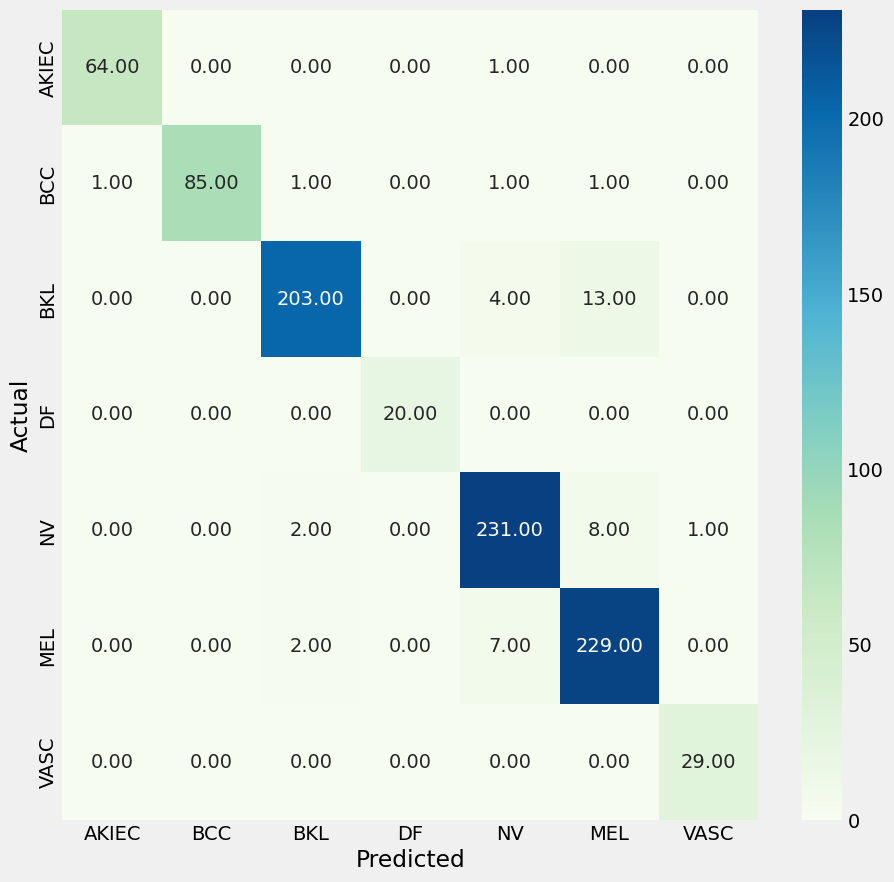

In [72]:
plot_confusionmat(confusion_mat, class_names)

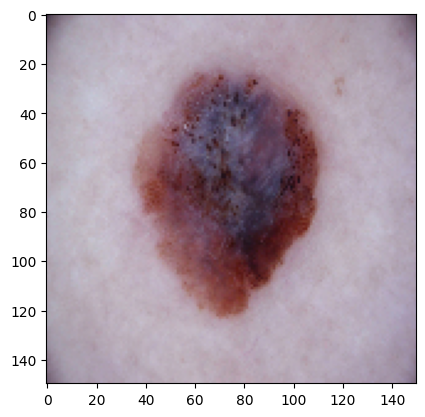

InvalidArgumentError: ignored

In [16]:
# test some picture here

# this is for general testing

imgs = []

# uploaded = files.upload()

# for fn in uploaded.keys():

#   path = fn
path = "/content/drive/MyDrive/Reskilling_DataScience/DeepLearning/Tensorflow/CNN/skin-cancer-mnist-ham10000/skin/mel/ISIC_0034287.jpg"
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()

img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
class_names_long = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesion']  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}")
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

In [ ]:
# test some picture here
# Model 3

imgs = []

path = 'download.png'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")